In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import matplotlib as mpl
from jupyter_dash import JupyterDash
import dash
from scipy.stats import linregress


from dash.dependencies import Output, State, Input

import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
#from dash import Dash, dcc, html
import plotly.graph_objs as go
import matplotlib as mpl
from scipy.optimize import curve_fit

In [2]:
pappu_a = pd.read_excel('pappu/Figure4A_B_C.xlsx', sheet_name=0, header = [3])
pappu_a = pappu_a.iloc[:, 1:17]

In [3]:
pappu_a.head()

,Size (nm),0.125 μM,Unnamed: 3,Unnamed: 4,0.25 μM,Unnamed: 6,Unnamed: 7,0.5 μM,Unnamed: 9,Unnamed: 10,1 μM,Unnamed: 12,Unnamed: 13,2 μM,Unnamed: 15,Unnamed: 16
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,226059,0,0,44266,0,0,90795,0,40964,0,0,0,0,0,0
2,25,1022404,185926,176869,637429,594488,485078,953347,834614,475181,45768,36957,84194,916456,423718,233628
3,35,1443696,617540,214104,2363798,2268963,2098707,4103932,2561687,2916626,816193,997847,1494445,2726831,1618465,1588671
4,45,760381,703863,1470804,7179925,7867058,5415059,11667153,9750937,8192770,3951288,3865732,2967841,7767336,5890381,4679236


In [4]:
pappu_columns = [] 
for i, column in enumerate(list(pappu_a.columns)[1:]): 
    if i%3 == 0: 
        pappu_columns += [re.findall('[0-9]\.[0-9]+|[0-9]',column)[0]+ f'_{j}' for j in range(3)] 
     
print(pappu_columns)

pappu_a.columns = ['Size'] + pappu_columns


pappu_a_conc = ['0.125', '0.25','0.5', '1', '2']

['0.125_0', '0.125_1', '0.125_2', '0.25_0', '0.25_1', '0.25_2', '0.5_0', '0.5_1', '0.5_2', '1_0', '1_1', '1_2', '2_0', '2_1', '2_2']


In [5]:
def k_moment(sizes, occurances, k):
    sizes = np.array(sizes)
    sizes = sizes[~np.isnan(sizes)]
    return np.sum(sizes**k * occurances) / np.sum(occurances)

def k_moment_random(df, concentration, pappu_conc, k):
    array_occurances = np.array(df)
    sizes = np.array(df['Size'])
    concentration_columns_idx = pappu_conc.index(concentration) 
    column_occurrances = array_occurances[:,concentration_columns_idx*3 + 1:\
         concentration_columns_idx*3 + 4]
    
    column_chosen_idx = np.random.choice([0,1,2], 1, p=[1/3, 1/3, 1/3])[0]
    column_chosen = column_occurrances[:, column_chosen_idx]

    k_th_moment = k_moment(sizes, column_chosen, k)

    return k_th_moment

In [6]:
def dict_moment(conc_list, df, pappu_conc, k):
    return {conc: np.mean([k_moment_random(df, conc, pappu_conc, k) for _ in range(100)])\
    for conc in pappu_conc}

def dict_moment_std(conc_list, df, pappu_conc, k):
    return {conc: np.std([k_moment_random(df, conc, pappu_conc, k) for _ in range(100)])\
    for conc in pappu_conc}

In [7]:
critical_c_a = 2

In [8]:
np.random.seed(33)
k_to_try = [0.5, 1, 1.5, 2]
critical_c_a = 2


k_array_lines_a = []
k_array_std_a = []
for k in k_to_try:
    k_mom = dict_moment(pappu_a_conc, pappu_a, pappu_a_conc, k)
    k_mom_std = dict_moment_std(pappu_a_conc, pappu_a, pappu_a_conc, k)
    k_mom = dict(map(lambda kv: (kv[0], (kv[1])**(-1/k)), k_mom.items()))
    k_array_lines_a.append(k_mom)
    k_array_std_a.append(k_mom_std)


In [9]:
def line(x, a, b):
    return a*x + b

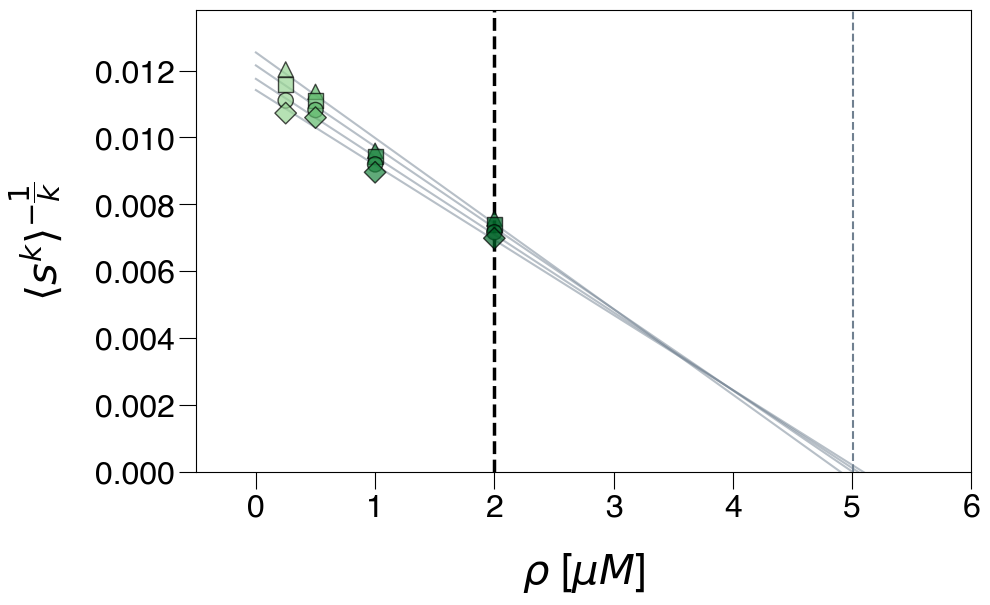

In [11]:
# Defining numpy seed
import matplotlib
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')

fig, ax = plt.subplots(figsize=(10, int(10 * 0.65)))
colors = ['C0', 'firebrick', 'forestgreen', 'darkviolet']
slopes_a = {}; intercepts_a = {}; r_a = {}; se_a = {}
rho_c_a_list = []
var_list_a = []
cmap = matplotlib.cm.get_cmap('Greens')
n_colors = len(pappu_a_conc) - 1
colors_perc = [0.4, 0.55, 0.77, 0.9]
colors = {conc: cmap(colors_perc[i]) for i, conc in enumerate(pappu_a_conc[1:])}
x_axis = np.linspace(0, 10, 1000)
markers = ['^', 's', 'o', 'D']
dataToSave = pd.DataFrame({'rho':list(map(lambda x: float(x), list(k_array_lines_a[0].keys())))[1:]})
from openpyxl import load_workbook
for i in range(len(k_to_try)):
    ax.scatter(list(map(lambda x: float(x), list(k_array_lines_a[i].keys())))[1:]\
        , list(k_array_lines_a[i].values())[1:], color = list(colors.values()), alpha = 0.7,\
            marker = markers[i], label = f'k = {k_to_try[i]}', zorder = 4, s = 120, edgecolors = 'black')

    dataToSave[f'k = {k_to_try[i]}'] = list(k_array_lines_a[i].values())[1:]
    
    slope, intercept, r, _, se = \
    linregress(list(map(lambda x: float(x), list(k_array_lines_a[i].keys())))[1:],\
    list(k_array_lines_a[i].values())[1:])

    popt, pcov = curve_fit(line, list(map(lambda x: float(x), list(k_array_lines_a[i].keys())))[1:],\
    list(k_array_lines_a[i].values())[1:])


    var_list_a.append((popt[1]**2 / popt[0]**4) * pcov[0][0] + (1 / popt[1] **2) * pcov[1][1])

    slopes_a[k_to_try[i]] = slope
    intercepts_a[k_to_try[i]] = intercept
    r_a[k_to_try[i]] = r
    se_a[k_to_try[i]] = se
    
    #ax.axvline(- intercept / slope, linestyle = '--',\
        #label = f'Inferred critical concentration, k = {k_to_try[i]}', color = colors[i], alpha = 1,\
            #zorder = 3)
    
    rho_c_a_list.append(- intercept / slope)

    ax.plot(x_axis, slope * x_axis + intercept, label = f'k = {k_to_try[i]} fit', color='slategrey',\
        alpha = 0.5, zorder = 2)
ax.axvline(critical_c_a, color = 'black', linestyle = '--', label = 'Critical concentration',\
    linewidth = 2.5)
final_rho_c_a = np.mean(rho_c_a_list)
ax.axvline(final_rho_c_a, color = 'slategrey', linestyle = '--', label = 'Critical concentration')

book = load_workbook('../../paperData.xlsx')
writer = pd.ExcelWriter('../../paperData.xlsx', engine = 'openpyxl', mode='a')
writer.book = book
#dataToSave.to_excel(writer, sheet_name = 'Fig4B', index = False)
writer.close()
ax.set_ylim(bottom = 0)
ax.set_xlim(right = 6)

ax.set_xlabel('$\\rho$ [$\mu M$]', fontsize = 30, labelpad = 20)
ax.set_ylabel('$ \left <  s^{k} \\right >^{-\dfrac{1}{k}} $', fontsize = 30, labelpad = 20)
ax.tick_params(axis='both', which='major', labelsize=23, length=12)

#ax.set_title('Estimation of the critical concetration - Pappu A', fontsize = 20, pad = 20)
#fig.savefig('../../paperPlots/pdfPlots/Fig4B.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../paperPlots/svgPlots/Fig4B.svg', dpi = 300, facecolor = 'white')


In [12]:
rho_c_a_list

[4.901263561419523, 5.002504183455086, 5.0481589547037595, 5.0913014059276005]

In [13]:
k =  np.sum(1 / np.array(var_list_a))
y_bar = np.sum(np.array(rho_c_a_list) / np.array(var_list_a)  ) / k
print(y_bar, 'pm', np.sqrt(1/k))

5.011109250499429 pm 0.21062009235832482


In [14]:
final_rho_c_a = np.mean(rho_c_a_list)
final_rho_c_a

5.010807026376492

In [15]:
k_to_try = [0.5, 1, 1.5, 2]
critical_c_a_final = final_rho_c_a

ratio_arr_list = []
k_mom_list = []
k_mom_1_list = []
k_mom_std = []
k_mom_1_std = []
for k in k_to_try:
    k_mom = dict_moment(pappu_a_conc, pappu_a, pappu_a_conc, k)
    k_mom_list.append(k_mom)
    k_mom_std.append(dict_moment_std(pappu_a_conc, pappu_a, pappu_a_conc, k))
    k_1_mom = dict_moment(pappu_a_conc, pappu_a, pappu_a_conc, k + 1)
    k_mom_1_list.append(k_1_mom)
    k_mom_1_std.append(dict_moment_std(pappu_a_conc, pappu_a, pappu_a_conc, k + 1))

    k_mom_arr = np.array(list(k_mom.values()))
    k_1_mom_arr = np.array(list(k_1_mom.values()))
    ratio_dict = {np.abs((float(conc) - critical_c_a_final)/critical_c_a_final):\
         k_1_mom_arr[i] / k_mom_arr[i] \
        for i, conc in enumerate(pappu_a_conc)}
    ratio_arr_list.append(ratio_dict)

In [16]:
err_dict = {}
for i in range(len(k_to_try)):
    err_dict[k_to_try[i]] = {}
    for conc in pappu_a_conc:
        
        yerr = np.sqrt( (1 / k_mom_1_list[i][conc])**2 * k_mom_1_std[i][conc] ** 2 +\
            (1 / k_mom_list[i][conc])**2 * k_mom_std[i][conc] ** 2)

        err_dict[k_to_try[i]][conc] = yerr

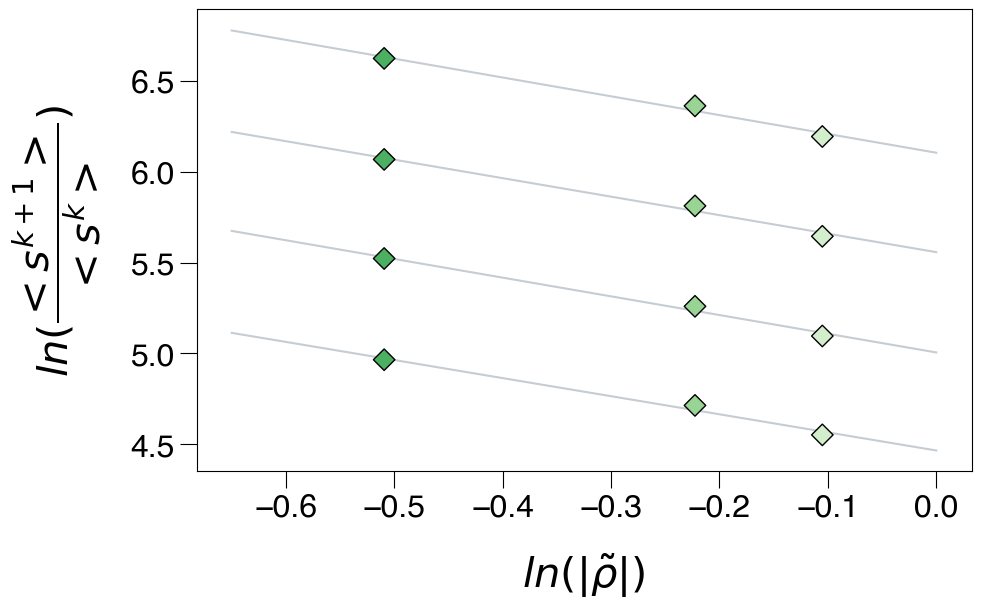

In [20]:
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')
x_axis = np.linspace(-0.65, -0, 100)
fig, ax = plt.subplots(figsize=(10, int(10 * 0.65)))
n_colors = len(pappu_a_conc) 
cmap = matplotlib.cm.get_cmap('Greens')
colors = {conc: cmap(np.linspace(0.2, 1, n_colors))[i] for i, conc in enumerate(pappu_a_conc[2:])}
from openpyxl import load_workbook
dataToSave = pd.DataFrame({'ln |tho_tilde|':np.log(np.array(list(ratio_arr_list[0].keys())[2:]))})
for i, dict_ in enumerate(ratio_arr_list):
    dataToSave['k = ' + str(k_to_try[i])] = np.log(np.exp(i)  * np.array(list(dict_.values())[2:]))
    ax.scatter(np.log(np.array(list(dict_.keys())))[2:],\
         np.log(np.exp(i/2) * np.array(list(dict_.values())))[2:], marker = 'D', zorder = 3,\
            color = list(colors.values()), label = f'k = {k_to_try[i]}', alpha = 1,\
                edgecolor = 'black', s = 120)


    slope, intercept, r, p, se = linregress(np.log(np.array(list(dict_.keys())))[2:],\
    np.log(np.array(list(dict_.values())))[2:])
    

    #ax.errorbar(np.log(np.array(list(dict_.keys())))[2:],\
    #        np.log(np.exp(i/2) * np.array(list(dict_.values())))[2:],\
    #        yerr = list(err_dict[k_to_try[i]].values())[2:],\
    #            zorder = 2, color = list(colors.values())[i], fmt = 'none', capsize =3, capthick = 1.5)

    ax.plot(x_axis, slope * x_axis + intercept + i/2, color = 'slategrey', alpha = 0.4, zorder = 1)


book = load_workbook('../../siData.xlsx')
writer = pd.ExcelWriter('../../siData.xlsx', engine = 'openpyxl', mode='a')
writer.book = book
dataToSave.to_excel(writer, sheet_name = 'FigSI1A', index = False)
writer.close()

#ax.grid(zorder = 1, which='both')      
#ax.set_xscale('log')  
#ax.set_yscale('log')  
  
#ax.set_title("$ \\varphi$ Estimation - Pappu A", fontsize=25)  
ax.set_xlabel('$ln( | \\tilde{\\rho} |)$', fontsize = 30, labelpad = 20)  
ax.set_ylabel('$ ln(\dfrac{ <s^{k+1}>}{<s^{k}>})$', fontsize=30, labelpad = 20)
#ax.legend(facecolor = 'aliceblue', fontsize = 12, edgecolor = 'black', shadow = True)

ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  
ax.get_xaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())  
ax.get_yaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())  
ax.tick_params(axis='both', which='major', labelsize=23, length=12)  
#fig.savefig('../../pdfPlots/FigS1a.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../pdfPlots/FigS1a.svg', dpi = 300, facecolor = 'white')
#ax.tick_params(axis='both', which='minor', labelsize=10, length=8)
#ax.minorticks_on()



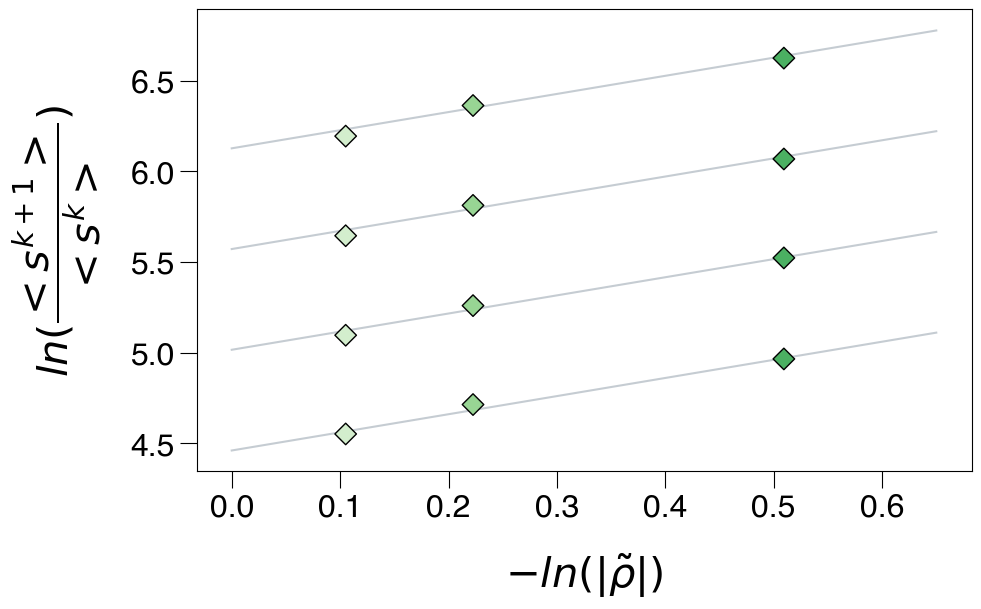

In [19]:
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')
x_axis = np.linspace(-0.65, -0, 100)
fig, ax = plt.subplots(figsize=(10, int(10 * 0.65)))
n_colors = len(pappu_a_conc) 
cmap = matplotlib.cm.get_cmap('Greens')
colors = {conc: cmap(np.linspace(0.2, 1, n_colors))[i] for i, conc in enumerate(pappu_a_conc[2:])}
for i, dict_ in enumerate(ratio_arr_list):
    ax.scatter(-np.log(np.array(list(dict_.keys())))[2:],\
         np.log(np.exp(i/2) * np.array(list(dict_.values())))[2:], marker = 'D', zorder = 3,\
            color = list(colors.values()), label = f'k = {k_to_try[i]}', alpha = 1,\
                edgecolor = 'black', s = 120)

    slope, intercept, r, p, se = linregress(np.log(np.array(list(dict_.keys())))[2:],\
    np.log(np.array(list(dict_.values())))[2:])

    #ax.errorbar(np.log(np.array(list(dict_.keys())))[2:],\
    #        np.log(np.exp(i/2) * np.array(list(dict_.values())))[2:],\
    #        yerr = list(err_dict[k_to_try[i]].values())[2:],\
    #            zorder = 2, color = list(colors.values())[i], fmt = 'none', capsize =3, capthick = 1.5)

    ax.plot(-x_axis, -1 * x_axis + 4.46 + i/1.8, color = 'slategrey', alpha = 0.4, zorder = 1)

#ax.grid(zorder = 1, which='both')      
#ax.set_xscale('log')  
#ax.set_yscale('log')  
  
#ax.set_title("$ \\varphi$ Estimation - Pappu A", fontsize=25)  
ax.set_xlabel('$-ln( | \\tilde{\\rho} |)$', fontsize = 30, labelpad = 20)  
ax.set_ylabel('$ ln(\dfrac{ <s^{k+1}>}{<s^{k}>})$', fontsize=30, labelpad = 20)
#ax.legend(facecolor = 'aliceblue', fontsize = 12, edgecolor = 'black', shadow = True)

ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())  
ax.get_xaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())  
ax.get_yaxis().set_minor_formatter(mpl.ticker.ScalarFormatter())  
ax.tick_params(axis='both', which='major', labelsize=23, length=12)  
#fig.savefig('../../pdfPlots/FigS1aReversed.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../pdfPlots/FigS1aReversed.svg', dpi = 300, facecolor = 'white')
#ax.tick_params(axis='both', which='minor', labelsize=10, length=8)
#ax.minorticks_on()



In [37]:
pappu_a_len = len(pappu_a) 
 
#ind = np.random.choice(3, 51)  
#mask = np.zeros((51, 3)) 
num_tries = 50 
dict_df_conc_a = {} 
 
for conc in pappu_a_conc: 
    dict_df_conc_a[conc] = pd.DataFrame(columns = [conc]) 
 
 
for _ in range(num_tries): 
    mask_dict_a = {} 
     
    for conc in pappu_a_conc: 
        mask = np.zeros((pappu_a_len, 3)) 
        mask[np.arange(pappu_a_len), np.random.choice(3, pappu_a_len)] = 1 
        mask_dict_a[conc] = mask 
 
 
 
    masked_pappu_a = {} 
     
 
    for conc in pappu_a_conc: 
        column_idx = pappu_a_conc.index(conc) 
        columns = np.array(pappu_a)[:, column_idx * 3 + 1: column_idx * 3 + 4] 
        columns_masked = np.sum(columns * mask_dict_a[conc], axis = 1) 
        masked_pappu_a[conc] = columns_masked 
 
 
 
    cum_pappu_a = {} 
     
 
    for conc in pappu_a_conc: 
        cum_pappu_a[conc] = 1 - np.insert(np.cumsum(masked_pappu_a[conc]), 0, 0)[:-1]/np.sum(masked_pappu_a[conc]) 
 
     
    dataframe_cum_a = pd.DataFrame(cum_pappu_a) 
     
 
    for conc in pappu_a_conc: 
        dict_df_conc_a[conc] = pd.concat([dict_df_conc_a[conc], dataframe_cum_a[conc]], axis = 1)

final_cum_dict_a = {}

for conc in pappu_a_conc:
    final_cum_dict_a[conc] = pd.DataFrame(np.nanmean(dict_df_conc_a[conc], axis = 1), columns = ['mean'])
    final_cum_dict_a[conc]['std'] = np.std(dict_df_conc_a[conc], axis = 1)

In [38]:
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',['skyblue',\
     'cornflowerblue', 'royalblue', 'orchid', 'blue', 'navy'], N=256)
cmap_err=LinearSegmentedColormap.from_list('rg',['green',\
     'seagreen', 'mediumseagreen', 'springgreen', 'limegreen', 'greenyellow'], N=256)

n_colors = len(pappu_a_conc)
colors_coll = {conc: cmap(np.linspace(0, 1, n_colors))[i] for i, conc in enumerate(pappu_a_conc)}

colors_err = {conc: cmap_err(np.linspace(0, 1, n_colors))[i] for i, conc in enumerate(pappu_a_conc)}

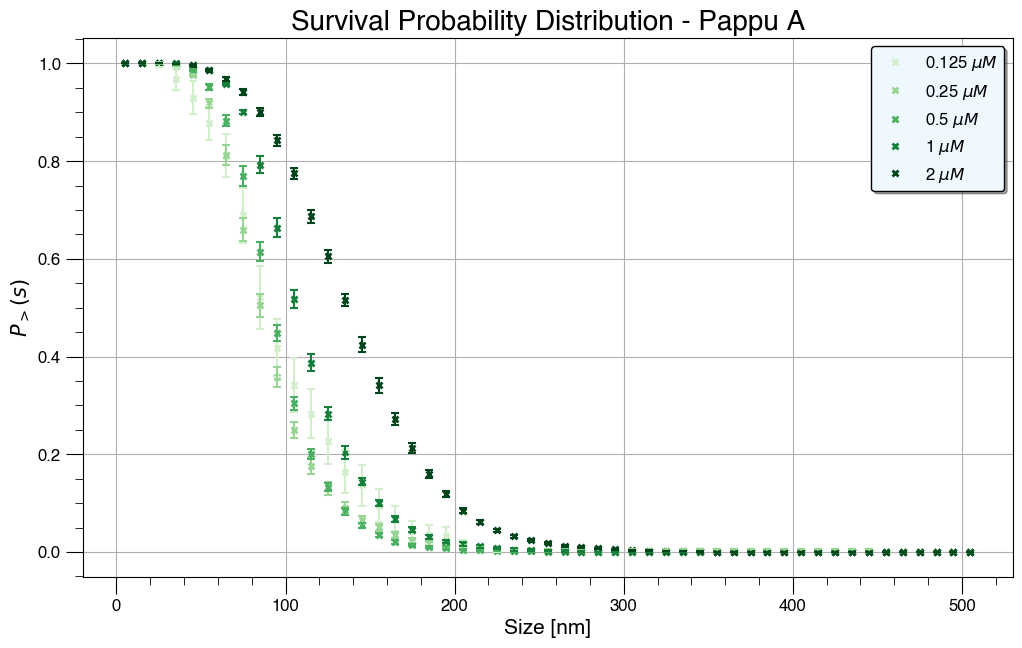

In [39]:
fig, ax = plt.subplots(figsize=(12, 7))
n_colors = len(pappu_a_conc) 
cmap = matplotlib.cm.get_cmap('Greens')
colors = {conc: cmap(np.linspace(0.2, 1, n_colors))[i] for i, conc in enumerate(pappu_a_conc)}
for conc in pappu_a_conc:
    ax.plot(pappu_a['Size'], final_cum_dict_a[conc]['mean'],\
        label = f'{conc} $\mu M$', markeredgewidth = 2, linestyle = 'None',\
             markersize = 5, zorder = 4, marker = 'x', color = colors[conc])
    #ax.plot(pappu_a['Size'], final_cum_dict_a[conc]['mean'],\
     #    markeredgewidth = 5, linestyle = 'None',\
      #       markersize = 7, zorder = 3, marker = 'x', alpha = 1, color = 'black')

    yerr = final_cum_dict_a[conc]['std']

    ax.errorbar(pappu_a['Size'], final_cum_dict_a[conc]['mean'],\
                yerr = yerr, fmt='none', zorder = 8, capsize = 3, capthick = 1.5, color = colors[conc])






ax.set_xlabel('Size [nm]', fontsize = 15)
ax.set_ylabel('$P_>(s)$', fontsize = 15)
ax.set_title('Survival Probability Distribution - Pappu A', fontsize = 20)

ax.grid(zorder=1)

ax.legend(facecolor = 'aliceblue', fontsize = 12, shadow = True, edgecolor = 'black')

ax.tick_params(axis='both', which='major', labelsize=12, length=12)
ax.tick_params(axis='both', which='minor', labelsize=12, length=6)
ax.minorticks_on()

In [40]:
np.random.seed(42)
rand_mean_dict = {conc: pd.DataFrame() for conc in pappu_a_conc}

for conc in pappu_a_conc:
    array_occurances = np.array(pappu_a)
    sizes = np.array(pappu_a['Size'])
    concentration_columns_idx = pappu_a_conc.index(conc) 
    column_occurrances = array_occurances[:,concentration_columns_idx*3 + 1:\
         concentration_columns_idx*3 + 4]

    for i in range(100):
          column_chosen_idx = np.random.choice([0,1,2], 1, p=[1/3, 1/3, 1/3])[0]
          column_chosen = column_occurrances[:, column_chosen_idx]
          rand_mean_dict[conc][f'{i}'] = column_chosen
    

means_dict = {}
std_dict = {}


for conc in pappu_a_conc:
    means_dict[conc] = np.mean(rand_mean_dict[conc], axis = 1)
    std_dict[conc] = np.std(rand_mean_dict[conc], axis = 1)


final_std_pappu_a = pd.DataFrame()
final_std_pappu_a['Size'] = pappu_a['Size']

means_pappu_a = pd.DataFrame(means_dict)
means_pappu_a.columns = list(map(lambda x: x + '_mean', list(means_pappu_a)))
std_pappu_a = pd.DataFrame(std_dict)
std_pappu_a.columns = list(map(lambda x: x + '_std', list(std_pappu_a)))

for i in range(len(pappu_a_conc)):
    final_std_pappu_a[list(means_pappu_a.columns)[i]] = means_pappu_a.iloc[:,i]
    final_std_pappu_a[list(std_pappu_a.columns)[i]] = std_pappu_a.iloc[:,i]



In [34]:
final_std_pappu_a

,Size,0.125_mean,0.125_std,0.25_mean,0.25_std,0.5_mean,0.5_std,1_mean,1_std,2_mean,2_std
0,5,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00
1,15,92684.19,1.111833e+05,16378.42,2.137182e+04,42074.21,3.682193e+04,0.00,0.000000e+00,0.00,0.000000e+00
2,25,526074.31,4.137628e+05,574270.87,6.499079e+04,749214.01,2.024904e+05,54892.36,2.042529e+04,512961.76,2.876402e+05
3,35,831198.80,5.335209e+05,2247867.47,1.115723e+05,3160462.21,6.493405e+05,1098629.08,2.816335e+05,1962416.28,5.245275e+05
4,45,964787.09,3.399556e+05,6803659.12,1.013873e+06,9815187.18,1.399870e+06,3605784.80,4.390404e+05,6054994.40,1.276058e+06
5,55,1279756.31,4.420918e+05,11834670.09,2.833501e+06,19182232.91,3.918740e+06,9475916.44,5.096129e+05,10734314.80,2.036834e+06
6,65,2514291.34,9.995874e+05,18653076.78,2.604706e+06,33469964.43,5.890826e+06,19191909.68,1.038776e+06,16701000.12,2.517482e+06
7,75,3087549.52,1.312613e+06,18511267.78,2.462599e+06,44548673.60,3.930529e+06,36413561.16,6.716066e+06,25093475.48,4.160646e+06
8,85,1924535.74,3.121889e+05,17337824.60,7.196190e+05,46589537.46,4.613626e+06,43836498.88,4.572306e+06,35597562.44,5.151520e+06
9,95,1504676.29,5.805958e+05,12663401.89,2.169667e+06,40533500.06,2.069528e+06,49599969.44,4.125924e+06,42210161.56,4.984041e+06


In [42]:
final_std_pappu_a.to_excel('pappuRandom.xlsx', sheet_name='untagged')

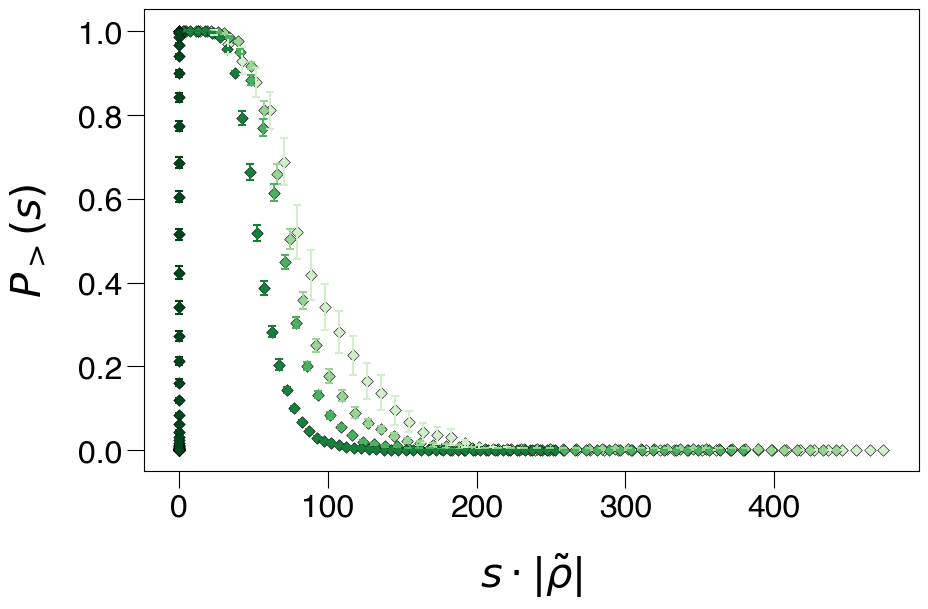

In [43]:
import matplotlib
import matplotlib.pyplot as plt 
plt.rc('font', family='Helvetica')
fig, ax = plt.subplots(figsize=(10, int(0.65 * 10)))
n_colors = len(pappu_a_conc) 

cmap = matplotlib.cm.get_cmap('Greens')
colors = {conc: cmap(np.linspace(0.2, 1, n_colors))[i] for i, conc in enumerate(pappu_a_conc)}


for conc in pappu_a_conc:
    ax.scatter(np.array(pappu_a['Size']) * np.abs((float(conc) - critical_c_a)/critical_c_a),\
         final_cum_dict_a[conc]['mean'], s = 35, label = f'{conc} $\mu M$',\
          marker = 'D', color = colors[conc], edgecolor = 'black', linewidth = 0.4)
    #ax.plot(np.array(pappu_a['Size']) * np.abs((float(conc) - critical_c_a)/critical_c_a),\
    #     final_cum_dict_a[conc]['mean'],\
    #    label = f'{conc} $\mu M$', markeredgewidth = 3, linestyle = 'None',\
    #         markersize = 3, zorder = 3, marker = 'D', color = 'black')
    #ax.plot(pappu_a['Size'], final_cum_dict_a[conc]['mean'],\
     #    markeredgewidth = 5, linestyle = 'None',\
      #       markersize = 7, zorder = 3, marker = 'x', alpha = 1, color = 'black')

    yerr = final_cum_dict_a[conc]['std']

    ax.errorbar(np.array(pappu_a['Size']) * np.abs((float(conc) - critical_c_a)/critical_c_a),\
       final_cum_dict_a[conc]['mean'],\
                yerr = yerr, fmt='none', zorder = 7, capsize = 3, capthick = 1.5,\
                    color = colors[conc], alpha = 1)
  






ax.set_xlabel('$s \cdot  | \\tilde{\\rho}| $', fontsize = 30, labelpad = 20)
ax.set_ylabel('$P_>(s)$', fontsize = 30, labelpad = 20)
#ax.set_title('Collapsed SDF experimental $\\rho_c$ - Pappu A', fontsize = 20,\
  #pad = 20)





ax.tick_params(axis='both', which='major', labelsize=23, length=12)
#fig.savefig('../../pdfPlots/Fig4C.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../pdfPlots/Fig4C.svg', dpi = 300, facecolor = 'white')


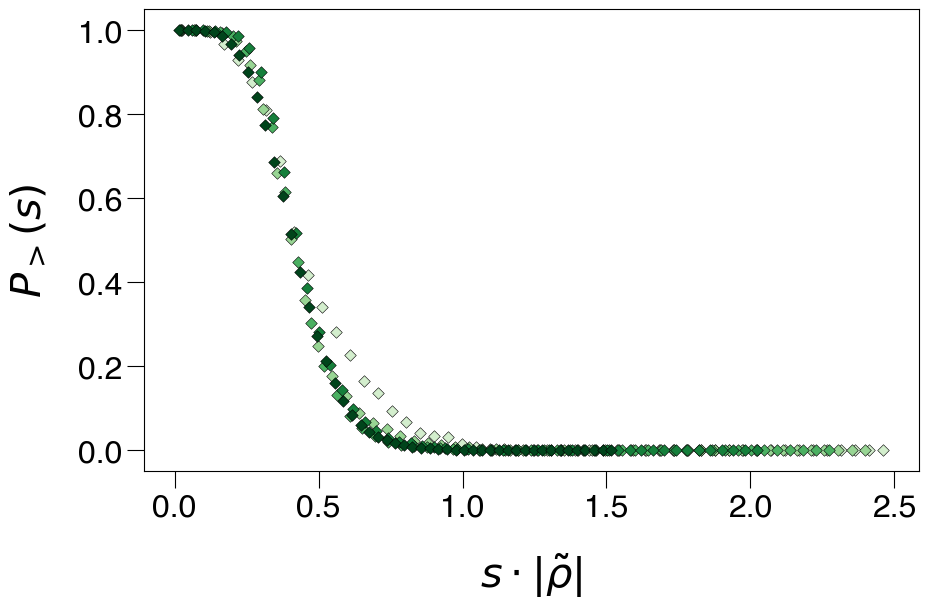

In [46]:
fig, ax = plt.subplots(figsize=(10, int(0.65 * 10)))
n_colors = len(pappu_a_conc) 
cmap = matplotlib.cm.get_cmap('Greens')
colors = {conc: cmap(np.linspace(0.2, 1, n_colors))[i] for i, conc in enumerate(pappu_a_conc)}

for conc in pappu_a_conc:
    ax.scatter(np.array(pappu_a['Size']) * np.abs((float(conc)\
         - critical_c_a_final)/critical_c_a_final)/200,\
         final_cum_dict_a[conc]['mean'],\
        label = f'{conc} $\mu M$', edgecolor = 'black', linewidth = 0.4,\
          zorder = 4, color = colors[conc], marker = 'D', s = 35)

    yerr = final_cum_dict_a[conc]['std']

    #ax.errorbar(np.array(pappu_a['Size']) * np.abs((float(conc)\
     #    - critical_c_a_final)/critical_c_a_final), final_cum_dict_a[conc]['mean'],\
      #          yerr = yerr, fmt='none', zorder = 8, capsize = 3, capthick = 1.5,\
       #             color = colors[conc])






ax.set_xlabel('$s \cdot  | \\tilde{\\rho}| $', fontsize = 30, labelpad = 20)
ax.set_ylabel('$P_>(s)$', fontsize = 30, labelpad = 20)
#ax.set_title('Collapsed SDF estimated $\\rho_c$ - Pappu A', fontsize = 20,\
 # pad = 20)





ax.tick_params(axis='both', which='major', labelsize=23, length=12)
#fig.savefig('../../newCollapse1.pdf', dpi = 300, facecolor = 'white', bbox_inches = 'tight')
#fig.savefig('../../pdfPlots/Fig4D.svg', dpi = 300, facecolor = 'white')